In [88]:
import pandas as pd
import json
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 7)
plt.rcParams.update({'font.size': 20})

In [13]:
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    try:
        training_data = []
        lines=[]
        with open(dataturks_JSON_FilePath, 'r') as f:
            lines = f.readlines()

        for line in lines:
            data = json.loads(line)
            text = data['content']
            entities = []
            for annotation in data['annotation']:
                #only a single point in text annotation.
                point = annotation['points'][0]
                labels = annotation['label']
                # handle both list of labels or a single label.
                if not isinstance(labels, list):
                    labels = [labels]

                for label in labels:
                    #dataturks indices are both inclusive [start, end] but spacy is not [start, end)
                    entities.append((point['start'], point['end'] + 1 ,label))
            training_data.append((text, {"entities": entities}))
        return training_data
    except Exception as e:
        logging.exception("Unable to process " + dataturks_JSON_FilePath + "\n" + "error = " + str(e))
        return None

In [1]:
with open('../data/manually_annotation.json', 'r') as f:
    lines = f.readlines()

In [4]:
for line in lines:
    manually_annotated_data = json.loads(line)

In [24]:
training_github_data = convert_dataturks_to_spacy('../data/traindata.json')
testing_github_data = convert_dataturks_to_spacy('../data/testdata.json')

In [71]:
entities = []
entity_types = []

for x,y in training_github_data:
    for entity in y['entities']:
        entities.append(x[entity[0]:entity[1]])
        entity_types.append(entity[2])
        
for x,y in testing_github_data:
    for entity in y['entities']:
        entities.append(x[entity[0]:entity[1]])
        entity_types.append(entity[2])

for x,y in manually_annotated_data:
    for entity in y['entities']:
        entities.append(x[entity[0]:entity[1]])
        entity_types.append(entity[2])

In [72]:
def correct_label(label):
    label_correction_dic = {'Email Address': 'EMAIL ADDRESS',
                            'College Name': 'COLLEGE NAME',
                            'Degree': 'DEGREE',
                            'Location': 'LOCATION',
                            'Skills': 'SKILLS',
                            'Companies worked at': 'COMPANIES WORKED AT',
                            'Name': 'NAME',
                            'DESIGNATION ': 'DESIGNATION',
                            'Designation': 'DESIGNATION',
                            'Years of Experience': 'YEARS OF EXPERIENCE',
                            'Graduation Year': 'GRADUATION YEAR'
                            }
    if label in label_correction_dic:
        return label_correction_dic[label]
    return label

In [73]:
for i in range(len(list(entity_types))):
    entity_types[i] = correct_label(entity_types[i])
entity_types

['COMPANIES WORKED AT',
 'COMPANIES WORKED AT',
 'COMPANIES WORKED AT',
 'SKILLS',
 'COMPANIES WORKED AT',
 'SKILLS',
 'GRADUATION YEAR',
 'COLLEGE NAME',
 'DEGREE',
 'GRADUATION YEAR',
 'COMPANIES WORKED AT',
 'DESIGNATION',
 'COMPANIES WORKED AT',
 'DESIGNATION',
 'COMPANIES WORKED AT',
 'DESIGNATION',
 'COMPANIES WORKED AT',
 'DESIGNATION',
 'COMPANIES WORKED AT',
 'COMPANIES WORKED AT',
 'COMPANIES WORKED AT',
 'EMAIL ADDRESS',
 'LOCATION',
 'DESIGNATION',
 'NAME',
 'COMPANIES WORKED AT',
 'COMPANIES WORKED AT',
 'COMPANIES WORKED AT',
 'SKILLS',
 'COLLEGE NAME',
 'DEGREE',
 'COLLEGE NAME',
 'DEGREE',
 'COMPANIES WORKED AT',
 'DESIGNATION',
 'LOCATION',
 'COMPANIES WORKED AT',
 'DESIGNATION',
 'LOCATION',
 'LOCATION',
 'LOCATION',
 'LOCATION',
 'COMPANIES WORKED AT',
 'DESIGNATION',
 'COMPANIES WORKED AT',
 'DESIGNATION',
 'DESIGNATION',
 'YEARS OF EXPERIENCE',
 'LOCATION',
 'LOCATION',
 'COMPANIES WORKED AT',
 'DESIGNATION',
 'NAME',
 'SKILLS',
 'EMAIL ADDRESS',
 'SKILLS',
 'GRADU

# EDA on entity_type

In [80]:
df = pd.DataFrame(data={'entity':entities, 'entity_types':entity_types})
df = df[~df['entity_types'].isin(['UNKNOWN','Unlabelled'])]
df

,entity,entity_types
0,Oracle,COMPANIES WORKED AT
1,Oracle,COMPANIES WORKED AT
2,Oracle,COMPANIES WORKED AT
3,"Languages: Core Java, Go Lang, Data Structures...",SKILLS
4,Oracle,COMPANIES WORKED AT
...,...,...
15438,Bunn High School\nBunn,COLLEGE NAME
15439,NC,LOCATION
15440,06/2005,GRADUATION YEAR
15441,High School Diploma,DEGREE


Text(0.5, 1.0, 'Entities Count')

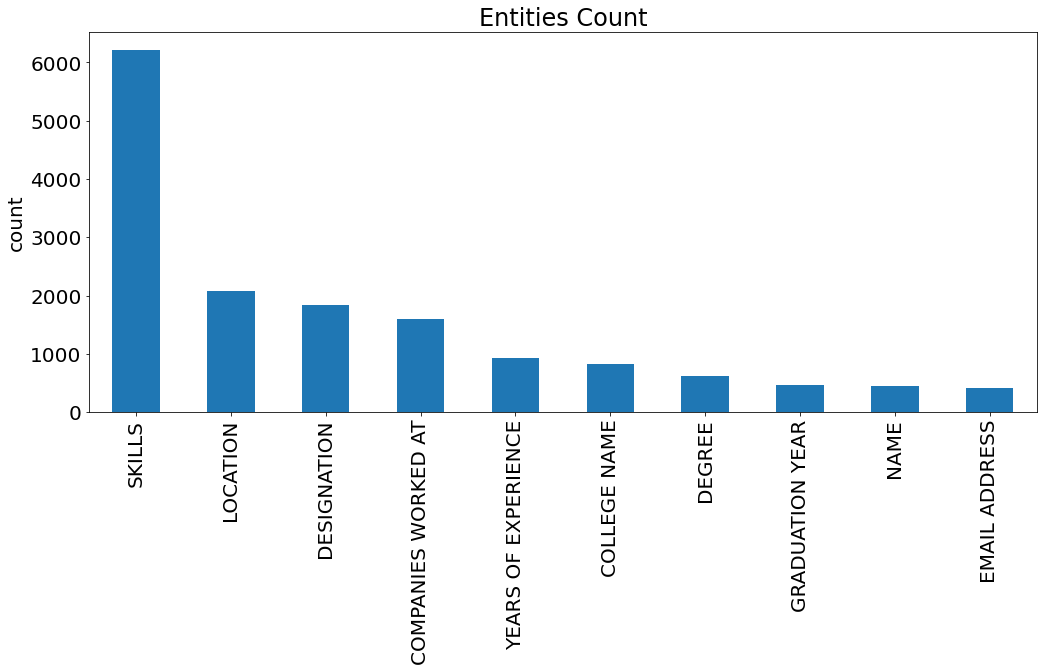

In [87]:
df['entity_types'].value_counts().plot.bar()
plt.ylabel('count')
plt.title('Entities Count')

# EDA on tokens

In [92]:
tokens = df['entity'].apply(word_tokenize)
words = tokens.apply(pd.Series).stack().reset_index(drop=True)
words = pd.DataFrame({'words':words})
words['words'] = words['words'].apply(lambda x: " ".join(x.lower() for x in x.split()))
words['words'] = words['words'].str.replace(r"[^a-zA-Z\d\_\s]", "")

#filter out stopwords in the content column
stop_words = set(stopwords.words('english'))
words['is_stop_words'] = words['words'].apply(lambda x: True if x in stop_words else False )
words = words[words['is_stop_words']==False]

#Reducing all words into their root words
ps = PorterStemmer()
words['words'] = words['words'].apply(lambda x: ps.stem(x))

words

<ipython-input-92-e11e4138e6e7>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  words['words'] = words['words'].str.replace(r"[^a-zA-Z\d\_\s]", "")


,words,is_stop_words
0,oracl,False
1,oracl,False
2,oracl,False
3,languag,False
4,,False
...,...,...
43138,high,False
43139,school,False
43140,diploma,False
43141,30,False


In [94]:
words = words[words['words']!='']
words

,words,is_stop_words
0,oracl,False
1,oracl,False
2,oracl,False
3,languag,False
5,core,False
...,...,...
43138,high,False
43139,school,False
43140,diploma,False
43141,30,False


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'year'),
  Text(1, 0, 'manag'),
  Text(2, 0, 'microsoft'),
  Text(3, 0, '1'),
  Text(4, 0, 'engin'),
  Text(5, 0, 'less'),
  Text(6, 0, 'univers'),
  Text(7, 0, 'develop'),
  Text(8, 0, 'oracl'),
  Text(9, 0, 'technolog'),
  Text(10, 0, 'skill'),
  Text(11, 0, 'scienc'),
  Text(12, 0, 'colleg'),
  Text(13, 0, 'data'),
  Text(14, 0, 'system')])

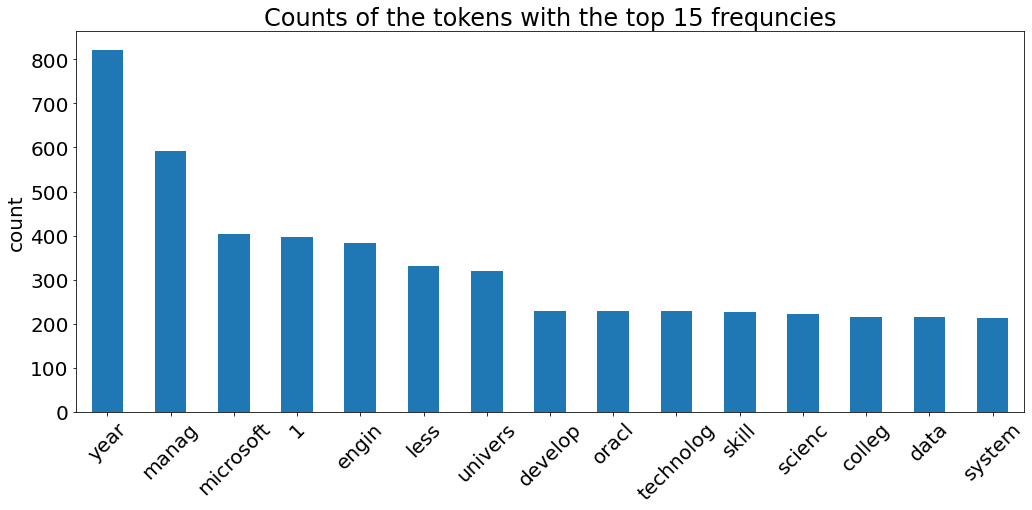

In [95]:
words['words'].value_counts()[:15].plot.bar()
plt.ylabel('count')
plt.title('Counts of the tokens with the top 15 frequncies')
plt.xticks(rotation=45)

In [98]:
tokens = df['entity']#.apply(word_tokenize)
words = tokens#.apply(pd.Series).stack().reset_index(drop=True)
words = pd.DataFrame({'words':words})
words['words'] = words['words'].apply(lambda x: " ".join(x.lower() for x in x.split()))
words['words'] = words['words'].str.replace(r"[^a-zA-Z\d\_\s]", "")

#filter out stopwords in the content column
stop_words = set(stopwords.words('english'))
words['is_stop_words'] = words['words'].apply(lambda x: True if x in stop_words else False )
words = words[words['is_stop_words']==False]

#Reducing all words into their root words
# ps = PorterStemmer()
# words['words'] = words['words'].apply(lambda x: ps.stem(x))

words = words[words['words']!='']
words

<ipython-input-98-081013864b11>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  words['words'] = words['words'].str.replace(r"[^a-zA-Z\d\_\s]", "")


,words,is_stop_words
0,oracle,False
1,oracle,False
2,oracle,False
3,languages core java go lang data structures a...,False
4,oracle,False
...,...,...
15438,bunn high school bunn,False
15439,nc,False
15440,062005,False
15441,high school diploma,False


Text(0.5, 1.0, 'Counts of the tokens with the top 15 frequncies')

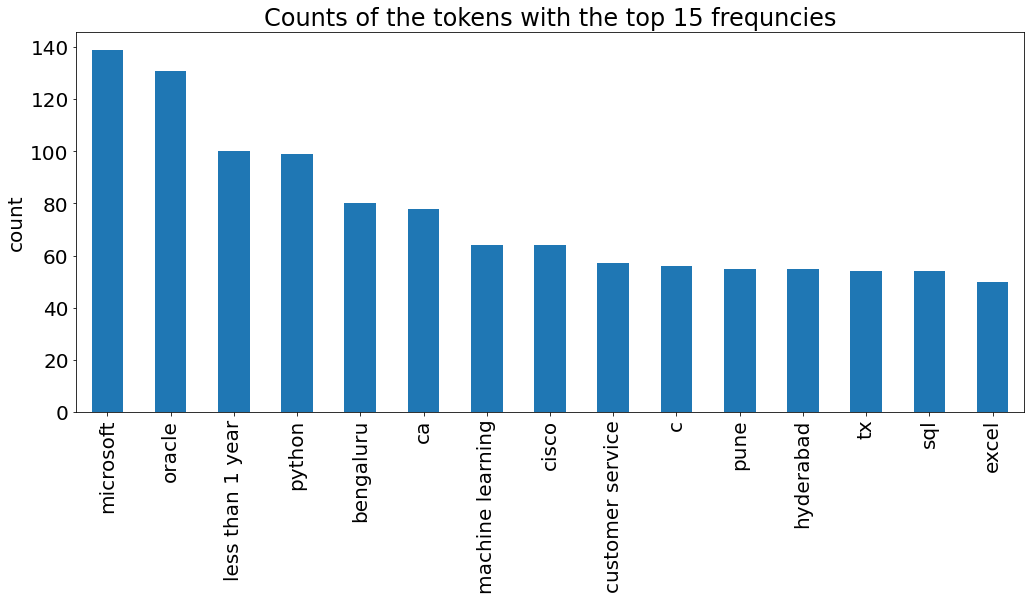

In [100]:
words['words'].value_counts()[:15].plot.bar()
plt.ylabel('count')
plt.title('Counts of the tokens with the top 15 frequncies')
# plt.xticks(rotation=45)